# README

Ce projet est essentiellement une classe de Graph avec deux parties principales : 

- La première est la fonction colored() qui tente de [colorer le graphe](https://en.wikipedia.org/wiki/Graph_coloring) en fonction d'une variable `max_colors` pour essayer. Si elle trouve une réponse, elle renvoie une structure de données `dict` avec la colorisation du graphique et le nombre de couleurs différentes nécessaires

- La seconde est une fonction hamiltonian() qui trouve un [chemin hamiltonien](https://en.wikipedia.org/wiki/Hamiltonian_path) (s'il existe) dans le graphique.

Pour les deux fonctionnalités, il existe des exemples simples et complexes avec des options de visualisation.


## Running this Jupyter

Afin de faire fonctionner ce jupyter notebook, vous devez installer [pysat](https://pysathq.github.io/installation.html) et [graphviz](https://anaconda.org/anaconda/graphviz) 

In [1]:
from pysat.solvers import Glucose4
import graphviz as gv

In [2]:
class Graph:
    def __init__(self, graph, solver=None):
        self.graph = graph
        self.n = self.__get_n()
        self.m = self.__get_m()
        self.edges = self.__get_edges()
        self.solver_constructor = solver if solver != None else Glucose4
        
        
    def color(self, colours_amt):
        """
        returns: 
        False if problem can't be solved with colours_amt (UNSAT)
        Dict of { node : color }, where each one represents the node and it's color
        """
        solver = self.solver_constructor()
        
        # each node must have one color
        for v in range(1, self.n + 1):
            solver.add_clause([K*self.n+v for K in range(colours_amt)])
        
        # for each edge, their nodes can't have the same color
        for u, v in self.edges:
            for K in range (colours_amt):
                solver.add_clause([-(K*self.n+u), -(K*self.n+v)])
        
        out = False
        if solver.solve():
            out = solver.get_model()
            out = self.__parse_colorized_output(out, colours_amt)
        
        solver.delete()
        
        return out
    
    def colored(self, max_colors=10):
        """
        returns: 
        (False, -1) if problem can't be solved with any value from 1 to max_colors (UNSAT)
        Tuple with (Dict of { node : color }, colours_amt) where each one represents the node and it's color
        and colours_amt is the amount of colors needed to color the graph
        """
        for attempt in range(1, max_colors+1):
            # print('Attempting to color with {} colors'.format(attempt))
            colors = self.color(attempt)
            
            if colors:
                # print('Colored with {} colors !'.format(attempt))
                break
                
            # print('Failed to color with {} colors'.format(attempt))
                
        if not colors:
            return (False, -1)

        return colors, attempt
        
    def hamiltonian(self):
        """
        returns: 
        False in case ther's not hamiltonian path
        The ordered indexes of the nodes of the hamiltonian path
        """
        
        solver = self.solver_constructor()
        n = self.n
        
        for i in range(n):
            solver.add_clause([n*j+i+1 for j in range(n)]) # every position in the path is used
            solver.add_clause([n*i+j+1 for j in range(n)]) # all nodes are in the path
    
            for j in range(n):
                for k in range(j+1, n):
                    solver.add_clause([-(n*j+i+1), -(n*k+i+1)]) # no node appears twice
                    solver.add_clause([-(n*i+j+1), -(n*i+k+1)]) # every node has a differnt position than other

        # This was hard to figure out: nodes which are not side by side in the graph can't be side by side in the path! 
        for k in range(n-1):
            for i in range(n):
                for j in range(n):
                    if i != j and not [i+1, j+1] in self.edges:    # carefull to not allow in case i==j
                        solver.add_clause([-(n*k+i+1), -(n*(k+1)+j+1)])
        
        out = False
        if solver.solve():
            path = []
            for i in range(n):
                for j in range(n):
                    if solver.get_model()[i*n+j] > 0:
                        path.append(j+1)
            out = path
            
            
        # petite "bricolage"
        if len(out) <= 1:
            out = False
        
        solver.delete()
        return out
                        
            
    def plot_colors(self, colors):
        """
        Plots this graph using the colors as parameter
        The colors can be obtained with a call to .colored() method
        
        Note: We support up to 8 colors. After that you problably shouldn't be trying to plot it :)
        """
        
        color_names = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'brown', 'pink']
        g = gv.Graph(strict=True)
    
        for u in self.graph.keys():
            g.node(str(u),color=color_names[colors[u]], style='filled')
            for v in self.graph[u]:
                g.edge(str(u), str(v))
                
        return g
    
    def plot_hamiltonian(self, path):
        """
        Plots the original graph but emphasises the discovered path
        """
        
        g = gv.Graph(strict=True)
    
        for u in self.graph.keys():
            for v in self.graph[u]:
                g.edge(str(u), str(v))

        if not path:
            print("There's no path !")
        else:
            for i in range(len(path)-1):
                g.edge(str(path[i]), str(path[i+1]), color='red', style='bold')

        return g
    
    @staticmethod
    def from_file(filename):
        f = open(filename, 'r')
        content = [c.strip() for c in f.readlines()]
        f.close()
        
        graph = {}
        for e in content:
            if e[0] == 'e':
                values = e.split(' ')
                u, v = int(values[1]), int(values[2])
                
                if u in graph.keys():
                    graph[u].add(v)
                else:
                    graph[u] = set([v])
                    
                if v in graph.keys():
                    graph[v].add(u)
                else:
                    graph[v] = set([u])
        
        for k in graph.keys():
            graph[k] = list(graph[k])
            
        return Graph(graph)
    
    def __get_n(self):
        return len(self.graph.keys())
    
    def __get_m(self):
        m = 0
        for k in self.graph.keys():
            m += len(self.graph[k])
        return m
    
    def __get_edges(self):
        edges = []
        for key in self.graph.keys():
            for connection in self.graph[key]:
                edges.append([key, connection])
        return edges
    
    def __parse_colorized_output(self, out, colors_amt):
        colors = {}
        for v in range(g.n):
            for K in range(colors_amt):
            
                if out[K*g.n+v] > 0:
                    colors[v+1] = K
                    break

        return colors

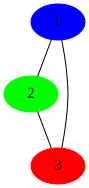

In [3]:
# First we demonstrate our class in a very simple graph
graph_simple = {
    1: [2],
    2: [3],
    3: [1]
}

g = Graph(graph_simple)
colors, _ = g.colored()
g.plot_colors(colors)

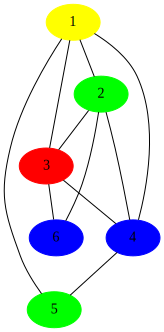

In [4]:
# Then we load a slight more complex graph
g = Graph.from_file('example.col')
colors, _ = g.colored()
g.plot_colors(colors)

In [5]:
# Finally, we move to a real, bigger problem
# Note: I'm not displaying the graph because it's too long, but we can check the main idea
g = Graph.from_file('myciel4.col')
colors, size = g.colored()

print('Graph myciel4 can be colorized with {} colors !'.format(size))
# g.plot_colors(colors)  # You can try to visualize it at your own risk :)

Graph myciel4 can be colorized with 5 colors !


In [6]:
# Now we move to a even harder instance ! Let's try myciel5.col
# WARNING: This cell may take several minutes to finish
g = Graph.from_file('myciel5.col')
colors, size = g.colored()

print('Graph myciel5 can be colorized with {} colors !'.format(size))

Graph myciel5 can be colorized with 6 colors !


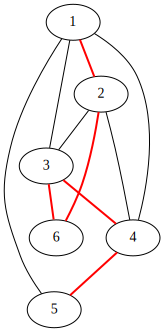

In [7]:
# Now we move the the hamiltonian path problem, first we test it with our old example.col file

g = Graph.from_file('example.col')
path = g.hamiltonian()
g.plot_hamiltonian(path)

There's no path !


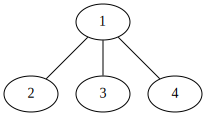

In [8]:
# Now we test in a different graph that doesn't have an hamiltonian path
graph_simple = {
    1: [2,3,4]
}
g = Graph(graph_simple)
path = g.hamiltonian()
g.plot_hamiltonian(path)